In [2]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from pydeseq2.dds import DeseqDataSet, DefaultInference
# from pydeseq2.ds import DeseqStats
import os

import decoupler as dc
import pertpy as pt
# ATTENTION: need for perpty of running jupternotbook
%matplotlib inline


from utils import preprocessing
from utils import DEG


BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
ADATA_PATH = f"/home/gdallagl/myworkdir/XDP/data/XDP/artificial_bican/geneset_001/zonated_objs_combined_with_md__combined__rep_001__ventral_matrix_keep_1.0_raw.h5ad"
ADATA_PATH_BASE = os.path.splitext(ADATA_PATH)[0]
ADATA_FOLDER = os.path.dirname(ADATA_PATH)

# Save folder fo results
# SAVE_FOLDER = "/home/gdallagl/myworkdir/XDP/data/XDP/DEG_results/DEG_zones_by_ct_slidetag"
# os.makedirs(SAVE_FOLDER, exist_ok=True)

2026-01-22 15:39:30 | [INFO] cffi mode is CFFI_MODE.ANY
2026-01-22 15:39:30 | [INFO] R home found: /usr/lib/R
2026-01-22 15:39:31 | [INFO] R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-22 15:39:31 | [INFO] LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64
2026-01-22 15:39:31 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save
2026-01-22 15:39:31 | [INFO] Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/lib64"
2026-01-22 15:39:31 

In [2]:
# Load Adata
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 191639 × 37905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'PREFIX', 'CELL_BARCODE', 'NUM_GENIC_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'num_retained_transcripts', 'pct_coding', 'pct_utr', 'pct_intergenic', 'pct_genic', 'pct_intronic', 'pct_mt', 'pct_ribosomal', 'frac_contamination', 'experiment', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'x', 'y', 'library', 'donor', 'x_um2', 'y_um2', 'unique_cell_ID', 'cb', 'Final_Zone_Assignments', 'Group_name.1', 'cell_type', 'Cohort', 'Biobank', 'Age.at.Death', 'Sex', 'Race', 'Ethnicity', 'Cause.of.Death', 'PMI', 'spn_type', 'case_control', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.5', 'Row.names', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'P

# Hyperparamters

In [3]:
print(adata.obs.case_control.unique())
print(adata.obs.Group_name.unique())
print(adata.obs.PMI.unique())

['control', 'case']
Categories (2, object): ['case', 'control']
['STRv_D1_MSN', 'STRd_D1_Matrix_MSN', 'STR_D1D2_Hybrid_MSN', 'STRd_D1_Striosome_MSN', 'STRd_D2_StrioMat_Hybrid_MSN', 'STRd_D2_Striosome_MSN', 'STRv_D1_NUDAP_MSN', 'STRd_D2_Matrix_MSN', 'STRv_D2_MSN']
Categories (9, object): ['STR_D1D2_Hybrid_MSN', 'STRd_D1_Matrix_MSN', 'STRd_D1_Striosome_MSN', 'STRd_D2_Matrix_MSN', ..., 'STRd_D2_Striosome_MSN', 'STRv_D1_MSN', 'STRv_D1_NUDAP_MSN', 'STRv_D2_MSN']
[ 6  9 16 17  8  3 18 14 12 11  1 19  5 15 10 13  4  2  7]


In [4]:
# name of cell tyoe vauble annotaton to use in this analsys
CT_FOR_DEG_VARIABLE = "spn_type" #"Group_name"
# name of Sample varibale
SAMPLE_VARIABLE = "donor_id"
# variable to test if differtially epxressed
CONTRAST_VARIABLE = "case_control"
# Level of contrat varibale to use as baseline
CONTRAST_BASELINE = "control"
# Level of contrat varibale to use as stimulated
CONTRAST_STIM = "case"
# Varibale combainstion to make groups (SAMPLE_VARIABLE non necessary)
COV_FOR_PSEUDOBULK = [CT_FOR_DEG_VARIABLE]
# Obs col names that groups psudocells in groups in which perfomr DEG in them --> it is made using the var in COV_FOR_PSEUDOBULK
GROUP_DEG_COL = "pseudobulk_group_for_DEG"


# Covariates to use for stat test
COVARIATES_FOR_DEG = ["Age.at.Death", "Sex", "PMI", "pct_mt", "pct_intronic"]
# Interesting cov (covarintes that are not used for the analys but still want to rpesevr in pesudobulk obs)
INTERESTING_COV = ["nCount_RNA", "nFeature_RNA", "pct_ribosomal", "library", "Cause.of.Death"]

# mitluple etst correction pvalue thr
ALPHA_MULTIPLE_TEST = 0.05
# Filter varibales for pseudobulk cells
MIN_CELLS_PER_PSUDOCELL=10
MIN_COUNTS_PER_PSEUDOCELL=1000
MIN_PSEUDOCELL_PER_GROUP=2
# Filter gens noisy/low expressed
MIN_COUNTS=10
LARGE_N=10
MIN_TOTAL_COUNTS=15
MIN_PROP_BY_EXPR=0.5
MIN_PROP_BY_PROP=0.1
MIN_SMPLS=2
#columns names
LOGFC_COL_NAME = "logfc"
ADJ_P_VAL_COL_NAME = "adjp"
GENE_COL_NAME = "gene"
N_TOP_GENES_TO_NAME = 10
# thr for gene signifcat
LOGFC_THR=0.1
PVAL_THR=0.05

FULL_MODEL = "~ " + " + ".join([CONTRAST_VARIABLE, *COVARIATES_FOR_DEG])
print(FULL_MODEL)
NULL_MODEL =  "~ " + " + ".join([*COVARIATES_FOR_DEG]) # FULL_MODEL withou main constrast
print(NULL_MODEL)


~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic
~ Age.at.Death + Sex + PMI + pct_mt + pct_intronic


# Pseudobulk

In [5]:
# Pusdobulk 
    # comnination (donor_id x Group_name x zone)
adata_pb_all = dc.pp.pseudobulk(
    adata=adata,
    sample_col=SAMPLE_VARIABLE, # Creates ONE pseudobulk per unique value in this column
    groups_col=[*COV_FOR_PSEUDOBULK], # Would create separate pseudobulks for each combination (together with sample_col)
    layer=None, # use .X with raw counts
    skip_checks=True,
    mode="sum",
)

# Col with all rpeusdbulk name concatemated
adata_pb_all.obs["pseudobulk_group"] = (
    adata_pb_all.obs[[SAMPLE_VARIABLE] + COV_FOR_PSEUDOBULK]
    .astype(str)          # make sure all values are strings
    .agg("-".join, axis=1)  # join cell-wise
)
adata_pb_all.obs[GROUP_DEG_COL] = (
    adata_pb_all.obs[COV_FOR_PSEUDOBULK]
    .astype(str)          # make sure all values are strings
    .agg("-".join, axis=1)  # join cell-wise
)

# Check row counts in .X
print(adata_pb_all.X)

[[ 921. 3097.   53. ...    0.    0.    0.]
 [ 640. 2269.   35. ...    0.    0.    0.]
 [1601. 5933.  111. ...    0.    0.    0.]
 ...
 [ 439. 1219.   28. ...    0.    0.    0.]
 [ 144.  438.    9. ...    0.    0.    0.]
 [ 398. 1067.   30. ...    0.    0.    0.]]


In [6]:
# Add covarite aggrgeated values
agg_dict = {}

for cov in [*COVARIATES_FOR_DEG, *INTERESTING_COV]:
    if pd.api.types.is_numeric_dtype(adata.obs[cov]):
        agg_dict[cov] = "mean"
    else:
        agg_dict[cov] = "first"
print(agg_dict)

celltype_zone_metadata = adata.obs.groupby([SAMPLE_VARIABLE, *COV_FOR_PSEUDOBULK]).agg(
    agg_dict
)

# Reset index to turn groupby keys into columns 
celltype_zone_metadata = celltype_zone_metadata.reset_index()
display(celltype_zone_metadata)

# Drop old covariate columns to avoid duplicates, then merge
adata_pb_all.obs = (
    adata_pb_all.obs
    .drop(columns=list(agg_dict.keys()), errors='ignore')  # Drop only the aggregated covariates
    .merge(
        celltype_zone_metadata,
        on=[SAMPLE_VARIABLE, *COV_FOR_PSEUDOBULK],  # Join on pseudobulk keys
        how='left'
    )
)
adata_pb_all.obs.set_index("pseudobulk_group", inplace=True)

adata_pb_all.obs

{'Age.at.Death': 'mean', 'Sex': 'first', 'PMI': 'mean', 'pct_mt': 'mean', 'pct_intronic': 'mean', 'nCount_RNA': 'mean', 'nFeature_RNA': 'mean', 'pct_ribosomal': 'mean', 'library': 'first', 'Cause.of.Death': 'first'}


/tmp/ipykernel_657906/2019152782.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_zone_metadata = adata.obs.groupby([SAMPLE_VARIABLE, *COV_FOR_PSEUDOBULK]).agg(


,donor_id,spn_type,Age.at.Death,Sex,PMI,pct_mt,pct_intronic,nCount_RNA,nFeature_RNA,pct_ribosomal,library,Cause.of.Death
0,MD6927,dorsal_matrix,48.0,Male,4.0,0.007350,0.662363,74610.459707,8958.956940,0.0,SI-TT-F5,Cardiac arrest
1,MD6927,espn,48.0,Male,4.0,0.012177,0.621210,63609.524051,8369.682700,0.0,SI-TT-F5,Cardiac arrest
2,MD6927,patch,48.0,Male,4.0,0.008589,0.656613,71594.125000,8775.108718,0.0,SI-TT-F5,Cardiac arrest
3,MD6927,ventral_matrix,48.0,Male,4.0,0.009597,0.637284,71948.889831,8933.056497,0.0,SI-TT-F5,Cardiac arrest
4,MD9129,dorsal_matrix,54.0,Male,15.0,0.004229,0.689396,74967.928756,8615.975389,0.0,SI-TT-C2,"Acute myocardial infarction, unspecified"
...,...,...,...,...,...,...,...,...,...,...,...,...
71,UMBEB23164,ventral_matrix,66.0,Male,14.0,0.007390,0.694825,82018.315425,8979.818024,0.0,SI-TT-C1,"Myocardial Infartion, Coronary Artery Disease"
72,UMBEB24013,dorsal_matrix,53.0,Male,10.0,0.001934,0.666153,60397.045086,8277.518492,0.0,SI-TT-F9,Mixed hyperlipidemia|Hypertensive crisis|Cardi...
73,UMBEB24013,espn,53.0,Male,10.0,0.002884,0.651726,47004.935909,7373.533802,0.0,SI-TT-F9,Mixed hyperlipidemia|Hypertensive crisis|Cardi...
74,UMBEB24013,patch,53.0,Male,10.0,0.002107,0.654623,60010.612231,8299.435024,0.0,SI-TT-F9,Mixed hyperlipidemia|Hypertensive crisis|Cardi...


,donor_id,spn_type,orig.ident,experiment,Neighborhood_name,Class_name,donor,Cohort,Biobank,Race,...,Age.at.Death,Sex,PMI,pct_mt,pct_intronic,nCount_RNA,nFeature_RNA,pct_ribosomal,library,Cause.of.Death
pseudobulk_group,,,,,,,,,,,,,,,,,,,,,
MD6927-dorsal_matrix,MD6927,dorsal_matrix,2025-06-03,s36,Subpallium GABA,CN LGE GABA,s36,"Bamboo, Arboretum B",Maryland (OCME),White,...,48.0,Male,4.0,0.007350,0.662363,74610.459707,8958.956940,0.0,SI-TT-F5,Cardiac arrest
MD9129-dorsal_matrix,MD9129,dorsal_matrix,2025-05-13,s29,Subpallium GABA,CN LGE GABA,s29,"Hibiscus, Arboretum C",Maryland (OCME),White,...,54.0,Male,15.0,0.004229,0.689396,74967.928756,8615.975389,0.0,SI-TT-C2,"Acute myocardial infarction, unspecified"
MD9162-dorsal_matrix,MD9162,dorsal_matrix,2025-05-14,s31,Subpallium GABA,CN LGE GABA,s31,"Hibiscus, Arboretum C",Maryland (OCME),White,...,45.0,Male,18.0,0.001404,0.709665,94659.242376,9368.933491,0.0,SI-TT-B9,"Heart failure, unspecified"
MD9244-dorsal_matrix,MD9244,dorsal_matrix,2025-04-09,s23,Subpallium GABA,CN LGE GABA,s23,"Fern, Arboretum B",Maryland (OCME),White,...,31.0,Male,3.0,0.003602,0.691461,87132.210314,8789.601117,0.0,SI-TT-E7,"Alcoholic liver disease, unspecified"
MD9261-dorsal_matrix,MD9261,dorsal_matrix,2025-06-03,s35,Subpallium GABA,CN LGE GABA,s35,"Hibiscus, Arboretum C",Maryland (OCME),White,...,69.0,Male,12.0,0.003741,0.671192,69339.198241,8967.155368,0.0,SI-TT-F1,Hypertensive heart disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMBEB23076-ventral_matrix,UMBEB23076,ventral_matrix,2025-03-18,s16,Subpallium GABA,CN LGE GABA,s16,"Daisy, Arboretum B",Miami,Black or African-American,...,66.0,Male,11.0,0.003516,0.618674,67362.012693,9171.113327,0.0,SI-TT-E5,"Atherosclerotic Heart Disease, Aortic Valve Di..."
UMBEB23127-ventral_matrix,UMBEB23127,ventral_matrix,2025-03-24,s21,Subpallium GABA,CN LGE GABA,s21,"Hibiscus, Arboretum C",Miami,White,...,56.0,Male,8.0,0.001916,0.594504,78891.734985,9702.099071,0.0,SI-TT-B4,"Obesity, unspecified|Hypertensive heart disease"
UMBEB23158-ventral_matrix,UMBEB23158,ventral_matrix,2025-05-29,s33,Subpallium GABA,CN LGE GABA,s33,Iris,Miami,White,...,59.0,Male,13.0,0.006726,0.657408,74867.552767,9155.561894,0.0,SI-TT-C5,Hypertensive heart disease|Atherosclerotic hea...


In [7]:
# # Minimal QC: remove genes with 0 variance -> not running SVA
# gene_vars = adata_pb_all.X.var(axis=0)
# gene_vars 
# non_zero_var = gene_vars > 0

# print(f"Total genes: {len(gene_vars)}")
# print(f"Zero variance genes: {(~non_zero_var).sum()}")
# print(f"Genes with variance > 0: {non_zero_var.sum()}")

# # Filer
# adata_pb_all = adata_pb_all[:, non_zero_var].copy()
# adata_pb_all

# Normalised version for SVA

In [8]:
adata_pb_all.layers["counts"] = adata_pb_all.X.copy()
sc.pp.normalize_total(adata_pb_all, target_sum=1e4, inplace=True)
sc.pp.log1p(adata_pb_all)
adata_pb_all.layers["log1p_norm"] = adata_pb_all.X.copy()
adata_pb_all.X = adata_pb_all.layers["counts"].copy()

In [9]:
# Save files needed in R for SVA
    # ATTENTION sva wants normalised data
    # ATTENTION in R we have genes x cells
log1p_norm_matrix_for_sva_df = pd.DataFrame(
    adata_pb_all.layers["log1p_norm"].T, # alredy dense, ATTENTION transpose
    index=adata_pb_all.var_names,  # Gene names
    columns=adata_pb_all.obs_names  # Sample names
)
log1p_norm_matrix_for_sva_df_path = f"{ADATA_PATH_BASE}_pseudobulk_R_matrix.csv"
log1p_norm_matrix_for_sva_df.to_csv(log1p_norm_matrix_for_sva_df_path)

# Save metadata
log1p_norm_matrix_metadata_for_sva_df = adata_pb_all.obs.copy()
log1p_norm_matrix_metadata_for_sva_df_path = f"{ADATA_PATH_BASE}_pseudobulk_R_metadata.csv"
log1p_norm_matrix_metadata_for_sva_df.to_csv(f"{ADATA_PATH_BASE}_pseudobulk_R_metadata.csv")

# Calculate SVA

Install SVA if needed:
```R
BiocManager::install("sva")
```

In [ ]:
SV_df_path = f"{ADATA_PATH_BASE}_pseudobulk_SVs_df.csv"

~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic
~ Age.at.Death + Sex + PMI + pct_mt + pct_intronic


In [11]:
import rpy2.robjects as ro
r = ro.r

# Import R packages
r('library(sva)')
r('library(limma)')

# Load data into R
r(f'''
    # Read data
    expr_matrix <- read.csv("{log1p_norm_matrix_for_sva_df_path}", row.names=1)
    metadata <- read.csv("{log1p_norm_matrix_metadata_for_sva_df_path}", row.names=1)

    # Ensure matrix is numeric
    expr_matrix <- as.matrix(expr_matrix)

    # Check dimensions
    print(paste("Expression matrix:", nrow(expr_matrix), "genes x", ncol(expr_matrix), "samples"))
    print(paste("Metadata:", nrow(metadata), "samples x", ncol(metadata), "covariates"))

    # Initialize empty dataframe for all SVs
    all_svs <- data.frame(row.names = rownames(metadata))

    # For each group
    for (group in unique(metadata${GROUP_DEG_COL})){{
        print(paste("\\n========== Processing:", group, "=========="))

        # Subset to this group only
        group_idx <- metadata${GROUP_DEG_COL} == group
        metadata_group <- metadata[group_idx, , drop=FALSE]
        expr_group <- expr_matrix[, group_idx, drop=FALSE]

        # Remove zero-variance genes
        gene_vars <- apply(expr_group, 1, var)
        expr_group <- expr_group[gene_vars > 0, , drop=FALSE]
        cat(sprintf("Genes with variance > 0: %d\\n", nrow(expr_group)))

        # Create design matrices --> Specific for this group
        # FULL MODEL
        mod <- model.matrix({FULL_MODEL}, data = metadata_group)
        # NULL MODEL
        mod0 <- model.matrix({NULL_MODEL}, data = metadata_group)
    
        # Run SVA
        print("Running SVA")
        svobj <- sva(
                    dat = expr_group, # ATTENTION: must be normlaised
                    mod = mod, 
                    mod0 = mod0,
                    n.sv = NULL,  # Auto-estimate number of SVs
                    method = "irw"
                )

        # Store SVs with group-specific names
        # ATTENTION: some groups coudl have differt numenr od SVs
        sv_df <- as.data.frame(svobj$sv)
        colnames(sv_df) <- paste0("SV", 1:svobj$n.sv)
        rownames(sv_df) <- rownames(metadata_group)

        # Add to combined dataframe
        for (col in colnames(sv_df)) {{
            if (!(col %in% colnames(all_svs))) {{
                all_svs[[col]] <- NA  # Initialize column if doesn't exist
            }}
            all_svs[rownames(sv_df), col] <- sv_df[[col]]
        }}
    }}

    # Save combined results
    write.csv(all_svs, "{SV_df_path}")

''')

2026-01-21 19:43:39 | [WARNING] R callback write-console: Loading required package: mgcv
  
2026-01-21 19:43:39 | [WARNING] R callback write-console: Loading required package: nlme
  


2026-01-21 19:43:40 | [WARNING] R callback write-console: This is mgcv 1.8-41. For overview type 'help("mgcv-package")'.
  
2026-01-21 19:43:40 | [WARNING] R callback write-console: Loading required package: genefilter
  
2026-01-21 19:43:44 | [WARNING] R callback write-console: Loading required package: BiocParallel
  


[1] "Expression matrix: 37905 genes x 76 samples"
[1] "Metadata: 76 samples x 25 covariates"
[1] "\n========== Processing: dorsal_matrix =========="
Genes with variance > 0: 36791
[1] "Running SVA"
Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  [1] "\n========== Processing: espn =========="
Genes with variance > 0: 36021
[1] "Running SVA"
Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  [1] "\n========== Processing: patch =========="
Genes with variance > 0: 36573
[1] "Running SVA"
Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  [1] "\n========== Processing: ventral_matrix =========="
Genes with variance > 0: 36634
[1] "Running SVA"
Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

In [12]:
# import rpy2.robjects as ro
# r = ro.r

# # Import R packages
# r('library(sva)')
# r('library(limma)')

# # Load data into R
# r(f'''
#     # Read data
#     expr_matrix <- read.csv("{log1p_norm_matrix_for_sva_df_path}", row.names=1)
#     metadata <- read.csv("{log1p_norm_matrix_metadata_for_sva_df_path}", row.names=1)

#     # Ensure matrix is numeric
#     expr_matrix <- as.matrix(expr_matrix)

#     # Check dimensions
#     print(paste("Expression matrix:", nrow(expr_matrix), "genes x", ncol(expr_matrix), "samples"))
#     print(paste("Metadata:", nrow(metadata), "samples x", ncol(metadata), "covariates"))

#     # Create design matrices
#     # FULL MODEL
#     mod <- model.matrix({FULL_MODEL}, data = metadata)
#     # NULL MODEL
#     mod0 <- model.matrix({NULL_MODEL}, data = metadata)

#     print("Full model dimensions:")
#     print(dim(mod))
#     print("Null model dimensions:")
#     print(dim(mod0))

#     # Run SVA
#     print("Running SVA")
#     svobj <- sva(
#                 dat = expr_matrix, # ATTENTION: must be normlaised
#                 mod = mod, 
#                 mod0 = mod0,
#                 n.sv = NULL,  # Auto-estimate number of SVs
#                 method = "irw"
#             )

#     # Print results
#     print(paste("Number of surrogate variables estimated:", svobj$n.sv))
#     print("Surrogate variables dimensions:")
#     print(dim(svobj$sv))

#     # Save results
#     print("Saving df")
#     sv_df <- as.data.frame(svobj$sv)
#     colnames(sv_df) <- paste0("SV", 1:ncol(sv_df))
#     rownames(sv_df) <- rownames(metadata) # for later join
#     write.csv(sv_df, "{SV_df_path}")

In [13]:
# cancat SVs to adata psuedoibulked
sv_df = pd.read_csv(SV_df_path, index_col=0)
print(sv_df.index)

# Join
adata_pb_all.obs = adata_pb_all.obs.join(sv_df) # join on index (same on both)

adata_pb_all.obs


Index(['MD6927-dorsal_matrix', 'MD9129-dorsal_matrix', 'MD9162-dorsal_matrix',
       'MD9244-dorsal_matrix', 'MD9261-dorsal_matrix', 'MS30499-dorsal_matrix',
       'MS706984-dorsal_matrix', 'MS876075-dorsal_matrix',
       'MS913848-dorsal_matrix', 'MS986638-dorsal_matrix',
       'PT13935-dorsal_matrix', 'UMBEB22074-dorsal_matrix',
       'UMBEB23033-dorsal_matrix', 'UMBEB23073-dorsal_matrix',
       'UMBEB23076-dorsal_matrix', 'UMBEB23127-dorsal_matrix',
       'UMBEB23158-dorsal_matrix', 'UMBEB23164-dorsal_matrix',
       'UMBEB24013-dorsal_matrix', 'MD6927-espn', 'MD9129-espn', 'MD9162-espn',
       'MD9244-espn', 'MD9261-espn', 'MS30499-espn', 'MS706984-espn',
       'MS876075-espn', 'MS913848-espn', 'MS986638-espn', 'PT13935-espn',
       'UMBEB22074-espn', 'UMBEB23033-espn', 'UMBEB23073-espn',
       'UMBEB23076-espn', 'UMBEB23127-espn', 'UMBEB23158-espn',
       'UMBEB23164-espn', 'UMBEB24013-espn', 'MD6927-patch', 'MD9129-patch',
       'MD9162-patch', 'MD9244-patch', 'MD926

,donor_id,spn_type,orig.ident,experiment,Neighborhood_name,Class_name,donor,Cohort,Biobank,Race,...,pct_mt,pct_intronic,nCount_RNA,nFeature_RNA,pct_ribosomal,library,Cause.of.Death,SV1,SV2,SV3
pseudobulk_group,,,,,,,,,,,,,,,,,,,,,
MD6927-dorsal_matrix,MD6927,dorsal_matrix,2025-06-03,s36,Subpallium GABA,CN LGE GABA,s36,"Bamboo, Arboretum B",Maryland (OCME),White,...,0.007350,0.662363,74610.459707,8958.956940,0.0,SI-TT-F5,Cardiac arrest,-0.109087,0.068044,0.008243
MD9129-dorsal_matrix,MD9129,dorsal_matrix,2025-05-13,s29,Subpallium GABA,CN LGE GABA,s29,"Hibiscus, Arboretum C",Maryland (OCME),White,...,0.004229,0.689396,74967.928756,8615.975389,0.0,SI-TT-C2,"Acute myocardial infarction, unspecified",-0.128106,-0.072984,0.193436
MD9162-dorsal_matrix,MD9162,dorsal_matrix,2025-05-14,s31,Subpallium GABA,CN LGE GABA,s31,"Hibiscus, Arboretum C",Maryland (OCME),White,...,0.001404,0.709665,94659.242376,9368.933491,0.0,SI-TT-B9,"Heart failure, unspecified",-0.032633,0.039491,0.225382
MD9244-dorsal_matrix,MD9244,dorsal_matrix,2025-04-09,s23,Subpallium GABA,CN LGE GABA,s23,"Fern, Arboretum B",Maryland (OCME),White,...,0.003602,0.691461,87132.210314,8789.601117,0.0,SI-TT-E7,"Alcoholic liver disease, unspecified",0.315572,-0.315089,0.394888
MD9261-dorsal_matrix,MD9261,dorsal_matrix,2025-06-03,s35,Subpallium GABA,CN LGE GABA,s35,"Hibiscus, Arboretum C",Maryland (OCME),White,...,0.003741,0.671192,69339.198241,8967.155368,0.0,SI-TT-F1,Hypertensive heart disease,-0.107967,0.061185,-0.044821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMBEB23076-ventral_matrix,UMBEB23076,ventral_matrix,2025-03-18,s16,Subpallium GABA,CN LGE GABA,s16,"Daisy, Arboretum B",Miami,Black or African-American,...,0.003516,0.618674,67362.012693,9171.113327,0.0,SI-TT-E5,"Atherosclerotic Heart Disease, Aortic Valve Di...",0.114300,-0.123931,0.031891
UMBEB23127-ventral_matrix,UMBEB23127,ventral_matrix,2025-03-24,s21,Subpallium GABA,CN LGE GABA,s21,"Hibiscus, Arboretum C",Miami,White,...,0.001916,0.594504,78891.734985,9702.099071,0.0,SI-TT-B4,"Obesity, unspecified|Hypertensive heart disease",0.238794,0.089449,0.044210
UMBEB23158-ventral_matrix,UMBEB23158,ventral_matrix,2025-05-29,s33,Subpallium GABA,CN LGE GABA,s33,Iris,Miami,White,...,0.006726,0.657408,74867.552767,9155.561894,0.0,SI-TT-C5,Hypertensive heart disease|Atherosclerotic hea...,0.080672,0.188285,0.008254


# Save complete psuedobulk adata

In [14]:
adata_pb_all.write(f"{ADATA_PATH_BASE}_pseudobulk.h5ad")

... storing 'pseudobulk_group_for_DEG' as categorical


In [5]:
adata_pb_all = sc.read_h5ad(f"{ADATA_PATH_BASE}_pseudobulk.h5ad")

# Make Design formula with SVs

In [22]:
# Add SVs
sv_cols = [c for c in adata_pb_all.obs.columns if "SV" in c]
DEG_FORMULA = FULL_MODEL + " + " + " + ".join(sv_cols)
DEG_FORMULA


'~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3'

### Verify if some variable are colliner

In case remove from Design Matrix

~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
['case_control', 'Age.at.Death', 'Sex', 'PMI', 'pct_mt', 'pct_intronic', 'SV1', 'SV2', 'SV3']


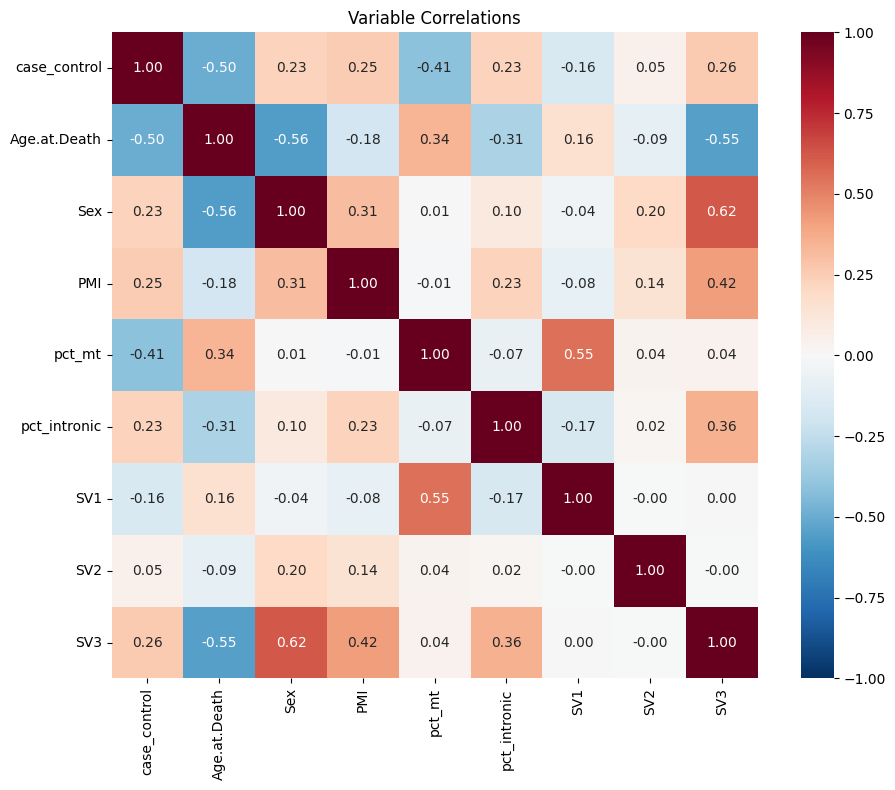


 High correlations (|r| > 0.7):


In [ ]:
#DEG.check_corr_cov_in_design(adata_pb_all, DEG_FORMULA, corr_thr=0.7, split=" + ")

In [18]:
# DEG_FORMULA = DEG_FORMULA.replace(" + SV3", "")
# DEG_FORMULA = DEG_FORMULA.replace(" + SV5", "")

# DEG_FORMULA

# Make DEG Analysis

In [9]:
# Read aritificla perturbed gene
    # checj min lofc
pert_df = pd.read_csv(f"{ADATA_FOLDER}/genes.csv")
print(np.abs(pert_df["log2fc"]).min(), LOGFC_THR)
display(pert_df.head(3))

0.1 0.1


,gene_id,log2fc,frac_applied,n_subjects_applied,subjects_applied
0,ENSG00000237280,0.522222,0.3,3,"MD9129,MS986638,UMBEB23076"
1,ENSG00000250027,0.733333,0.7,7,"MD9129,MS30499,MS706984,MS876075,MS986638,UMBE..."
2,ENSG00000289321,-0.733333,0.4,4,"MD6927,MS30499,MS876075,MS986638"


In [21]:
DEG_FORMULA = FULL_MODEL
FULL_MODEL

'~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic'

In [23]:
for psuedobulk_group_for_deg in adata_pb_all.obs[GROUP_DEG_COL].unique():
    
    results_folder = f'{ADATA_FOLDER}/SV_results/{psuedobulk_group_for_deg}'
    os.makedirs(results_folder, exist_ok=True)

    try:
        original_show = plt.show

        df = DEG.DEG_deseq2_edgeR(
                adata_pb_all=adata_pb_all,
                psuedobulk_group_for_deg=psuedobulk_group_for_deg,
                psuedobulk_group_for_deg_col=GROUP_DEG_COL,
                design_formula=DEG_FORMULA,
                save_folder=results_folder,
                SAMPLE_VARIABLE=SAMPLE_VARIABLE,
                CONTRAST_VARIABLE=CONTRAST_VARIABLE,
                MIN_CELLS_PER_PSUDOCELL=MIN_CELLS_PER_PSUDOCELL,
                MIN_COUNTS_PER_PSEUDOCELL=MIN_COUNTS_PER_PSEUDOCELL,
                MIN_PSEUDOCELL_PER_GROUP=MIN_PSEUDOCELL_PER_GROUP,
                MIN_COUNTS=MIN_COUNTS,
                LARGE_N=LARGE_N,
                MIN_TOTAL_COUNTS=MIN_TOTAL_COUNTS,
                MIN_PROP_BY_EXPR=MIN_PROP_BY_EXPR,
                MIN_PROP_BY_PROP=MIN_PROP_BY_PROP,
                MIN_SMPLS=MIN_SMPLS,
                CONTRAST_BASELINE=CONTRAST_BASELINE,
                CONTRAST_STIM=CONTRAST_STIM,
                ALPHA_MULTIPLE_TEST=ALPHA_MULTIPLE_TEST,
                LOGFC_THR=LOGFC_THR,
                PVAL_THR=PVAL_THR,
                N_TOP_GENES_TO_NAME=N_TOP_GENES_TO_NAME,
                GENE_COL_NAME=GENE_COL_NAME,
                LOGFC_COL_NAME=LOGFC_COL_NAME,
                ADJ_P_VAL_COL_NAME=ADJ_P_VAL_COL_NAME,
                calculate_umap=False
            )
    finally:
        plt.show = original_show


    # Gradient gene
    #    res_df_edgeR["is_gradient_gene"] = res_df_edgeR["gene"].isin(gradient_genes)


    # True DEG gene
    df["is_true_DEG"] = df[GENE_COL_NAME].isin(pert_df.gene_id.tolist())
    for _, df_g in df.groupby("method"):
        print(_)
        display(pd.crosstab(df_g["is_true_DEG"], df_g["is_significant"]))

    #break


            #########################
            ### Processing psudobulk group: dorsal_matrix
            #########################
            

Corrected dsign Matrix: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
['case_control', 'Age.at.Death', 'Sex', 'PMI', 'pct_mt', 'pct_intronic', 'SV1', 'SV2', 'SV3']

 High correlations (|r| > 0.7):
Samples per group: {'case': np.int64(10), 'control': np.int64(9)}

Design formula: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3



2026-01-22 12:47:51 | [WARNING] R callback write-console: In addition:   
2026-01-22 12:47:51 | [WARNING] R callback write-console: Warning messages:
  
2026-01-22 12:47:51 | [WARNING] R callback write-console: 1:   
2026-01-22 12:47:51 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:47:51 | [WARNING] R callback write-console: 
   
2026-01-22 12:47:51 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
2026-01-22 12:47:51 | [WARNING] R callback write-console: 2:   
2026-01-22 12:47:51 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:47:51 | [WARNING] R callback write-console: 
   
2026-01-22 12:47:51 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: overflow encountered in multiply
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
Fitting dispersions...
... done in 1.97 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 2.28 seconds.

Fitting LFCs...
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: overflow encountered in multiply
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: invalid value encountered in matmul
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
... done in 2.21 seconds.

Calculating cook's distance...
... done in 0.02 sec

Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
A1BG         729.304174       -0.245779  0.075297 -3.264134  0.001098   
A1BG-AS1    2368.217744       -0.032366  0.095656 -0.338354  0.735097   
A2M-AS1      395.069993        0.097263  0.166671  0.583565  0.559513   
A2ML1        306.398105        0.061435  0.160030  0.383897  0.701055   
A2ML1-AS1   1598.328908        0.157711  0.136677  1.153898  0.248542   
...                 ...             ...       ...       ...       ...   
ZXDC       12841.624615       -0.010168  0.077592 -0.131045  0.895740   
ZYG11B      9708.849907        0.049379  0.062484  0.790266  0.429372   
ZYX         2062.244708       -0.002057  0.185592 -0.011081  0.991159   
ZZEF1      15690.383044       -0.048683  0.050388 -0.966154  0.333967   
ZZZ3       27429.915950        0.103947  0.058420  1.779294  0.075192   

               padj  
A1BG

is_significant,False,True
is_true_DEG,,
False,16651,10
True,217,53


edgeR


is_significant,False,True
is_true_DEG,,
False,16660,1
True,237,33



            #########################
            ### Processing psudobulk group: espn
            #########################
            

Corrected dsign Matrix: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
['case_control', 'Age.at.Death', 'Sex', 'PMI', 'pct_mt', 'pct_intronic', 'SV1', 'SV2', 'SV3']

 High correlations (|r| > 0.7):
Samples per group: {'case': np.int64(10), 'control': np.int64(9)}

Design formula: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3



2026-01-22 12:48:25 | [WARNING] R callback write-console: In addition:   
2026-01-22 12:48:25 | [WARNING] R callback write-console: Warning messages:
  
2026-01-22 12:48:25 | [WARNING] R callback write-console: 1:   
2026-01-22 12:48:25 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:48:25 | [WARNING] R callback write-console: 
   
2026-01-22 12:48:25 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
2026-01-22 12:48:25 | [WARNING] R callback write-console: 2:   
2026-01-22 12:48:25 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:48:25 | [WARNING] R callback write-console: 
   
2026-01-22 12:48:25 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
Fitting dispersions...
... done in 1.81 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 2.00 seconds.

Fitting LFCs...
... done in 2.00 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.11 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        250.679297       -0.119850  0.165516 -0.724095  0.469007  0.999616
A1BG-AS1    584.757407       -0.091206  0.133227 -0.684594  0.493600  0.999616
A2M-AS1     151.548826        0.091553  0.157536  0.581153  0.561138  0.999616
A2ML1-AS1   335.038289        0.100123  0.171541  0.583671  0.559442  0.999616
AAAS        871.563453       -0.116733  0.160345 -0.728011  0.466607  0.999616
...                ...             ...       ...       ...       ...       ...
ZXDC       4111.194335       -0.027245  0.082181 -0.331525  0.740248  0.999616
ZYG11B     5026.961721        0.051380  0.064291  0.799171  0.424191  0.999616
ZYX         830.262859        0.000577  0.120864  0.004777  0.996189  0.999616
ZZEF1      6141.657292       -0.007219  0.079027 -0.091343  0.927220  0.999616
ZZZ3       9244.969070        0.10

is_significant,False,True
is_true_DEG,,
False,15793,1
True,222,47


edgeR


is_significant,False,True
is_true_DEG,,
False,15794,0
True,234,35



            #########################
            ### Processing psudobulk group: patch
            #########################
            

Corrected dsign Matrix: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
['case_control', 'Age.at.Death', 'Sex', 'PMI', 'pct_mt', 'pct_intronic', 'SV1', 'SV2', 'SV3']

 High correlations (|r| > 0.7):
Samples per group: {'case': np.int64(10), 'control': np.int64(9)}

Design formula: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3



2026-01-22 12:48:58 | [WARNING] R callback write-console: In addition:   
2026-01-22 12:48:58 | [WARNING] R callback write-console: Warning messages:
  
2026-01-22 12:48:58 | [WARNING] R callback write-console: 1:   
2026-01-22 12:48:58 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:48:58 | [WARNING] R callback write-console: 
   
2026-01-22 12:48:58 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
2026-01-22 12:48:58 | [WARNING] R callback write-console: 2:   
2026-01-22 12:48:58 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:48:58 | [WARNING] R callback write-console: 
   
2026-01-22 12:48:58 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: invalid value encountered in matmul
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: overflow encountered in multiply
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/pydeseq2/utils.py:385: RuntimeWarning: invalid value encountered in matmul
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
Fitting dispersions...
... done in 2.23 seconds.

Fitting dispersion trend curve...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 2.18 seconds.

Fitting LFCs...
... done in 1.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.64 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        351.704117       -0.097216  0.106247 -0.914999  0.360192  0.999871
A1BG-AS1   1270.663610       -0.019119  0.116596 -0.163973  0.869753  0.999871
A2M          94.958487        0.735741  0.517517  1.421676  0.155120  0.999871
A2M-AS1     195.861254        0.015351  0.166853  0.092002  0.926697  0.999871
A2ML1       158.990539       -0.033417  0.218819 -0.152713  0.878624  0.999871
...                ...             ...       ...       ...       ...       ...
ZXDC       6706.239281        0.021847  0.072963  0.299426  0.764615  0.999871
ZYG11B     5106.675481        0.031276  0.071740  0.435965  0.662862  0.999871
ZYX         936.113996       -0.029058  0.151794 -0.191432  0.848187  0.999871
ZZEF1      8101.738178       -0.063557  0.062326 -1.019758  0.307843  0.999871
ZZZ3      13890.402231        0.12

is_significant,False,True
is_true_DEG,,
False,16812,6
True,222,49


edgeR


is_significant,False,True
is_true_DEG,,
False,16815,3
True,240,31



            #########################
            ### Processing psudobulk group: ventral_matrix
            #########################
            

Corrected dsign Matrix: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3
['case_control', 'Age.at.Death', 'Sex', 'PMI', 'pct_mt', 'pct_intronic', 'SV1', 'SV2', 'SV3']

 High correlations (|r| > 0.7):
Samples per group: {'case': np.int64(10), 'control': np.int64(9)}

Design formula: ~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + SV1 + SV2 + SV3



2026-01-22 12:49:32 | [WARNING] R callback write-console: In addition:   
2026-01-22 12:49:32 | [WARNING] R callback write-console: Warning messages:
  
2026-01-22 12:49:32 | [WARNING] R callback write-console: 1:   
2026-01-22 12:49:32 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:49:32 | [WARNING] R callback write-console: 
   
2026-01-22 12:49:32 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
2026-01-22 12:49:32 | [WARNING] R callback write-console: 2:   
2026-01-22 12:49:32 | [WARNING] R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
2026-01-22 12:49:32 | [WARNING] R callback write-console: 
   
2026-01-22 12:49:32 | [WARNING] R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.85 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 2.28 seconds.

Fitting LFCs...
... done in 1.97 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.73 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        547.775617       -0.065477  0.107669 -0.608136  0.543097  0.999923
A1BG-AS1   1481.191181       -0.087482  0.125757 -0.695644  0.486652  0.999923
A2M         182.278597        0.551771  0.340243  1.621700  0.104868  0.999923
A2M-AS1     268.566582        0.159486  0.177827  0.896863  0.369792  0.999923
A2ML1       200.061312       -0.184231  0.199871 -0.921752  0.356658  0.999923
...                ...             ...       ...       ...       ...       ...
ZXDC       7755.455723        0.024265  0.073729  0.329105  0.742076  0.999923
ZYG11B     6220.129108        0.002112  0.081845  0.025805  0.979413  0.999923
ZYX        1447.359177        0.075914  0.102928  0.737540  0.460794  0.999923
ZZEF1      9397.654587       -0.022701  0.052980 -0.428479  0.668302  0.999923
ZZZ3      17657.399614        0.12

is_significant,False,True
is_true_DEG,,
False,16899,7
True,221,50


edgeR


is_significant,False,True
is_true_DEG,,
False,16905,1
True,247,24


Deseq2


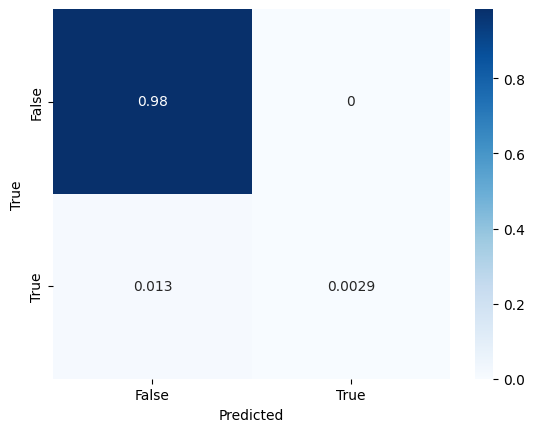


Precision: 1.000
Recall:    0.185
F1 Score:  0.312
Accuracy:  0.987


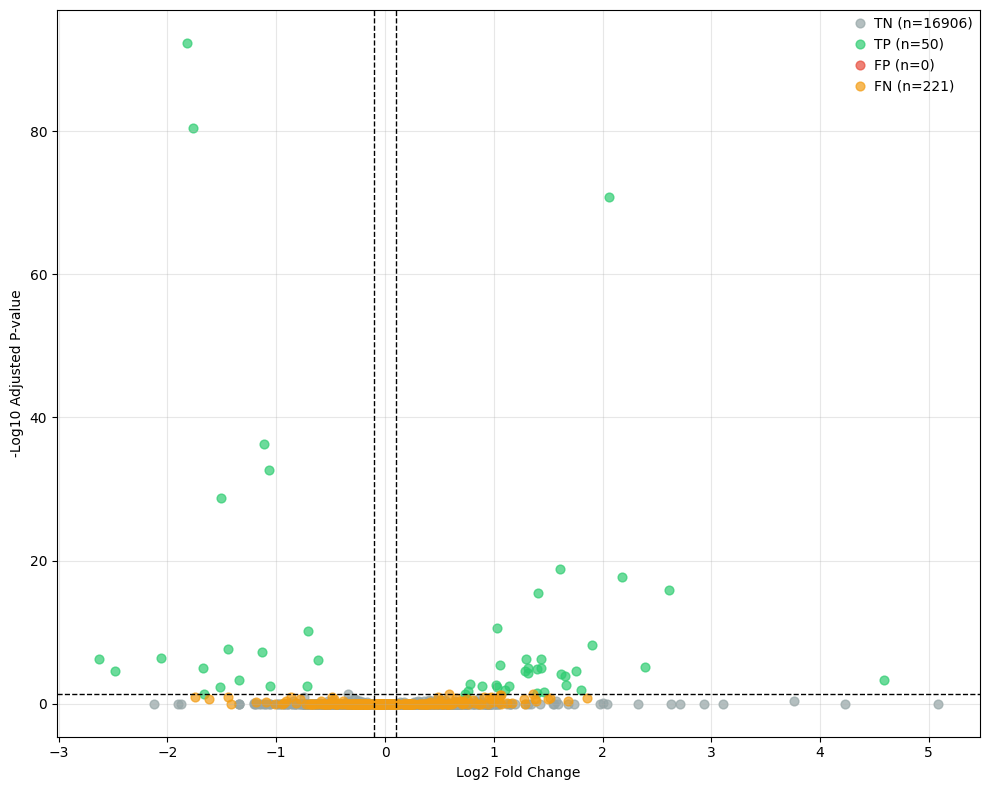

edgeR


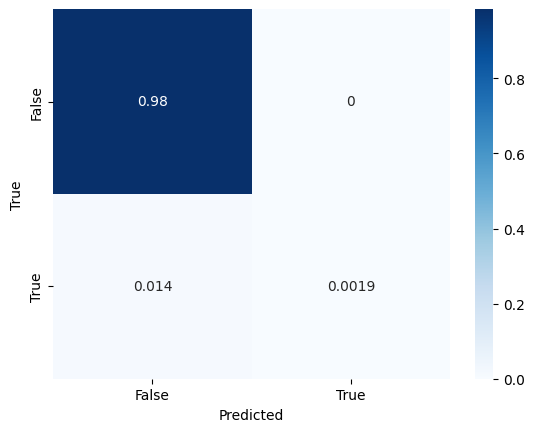


Precision: 1.000
Recall:    0.118
F1 Score:  0.211
Accuracy:  0.986


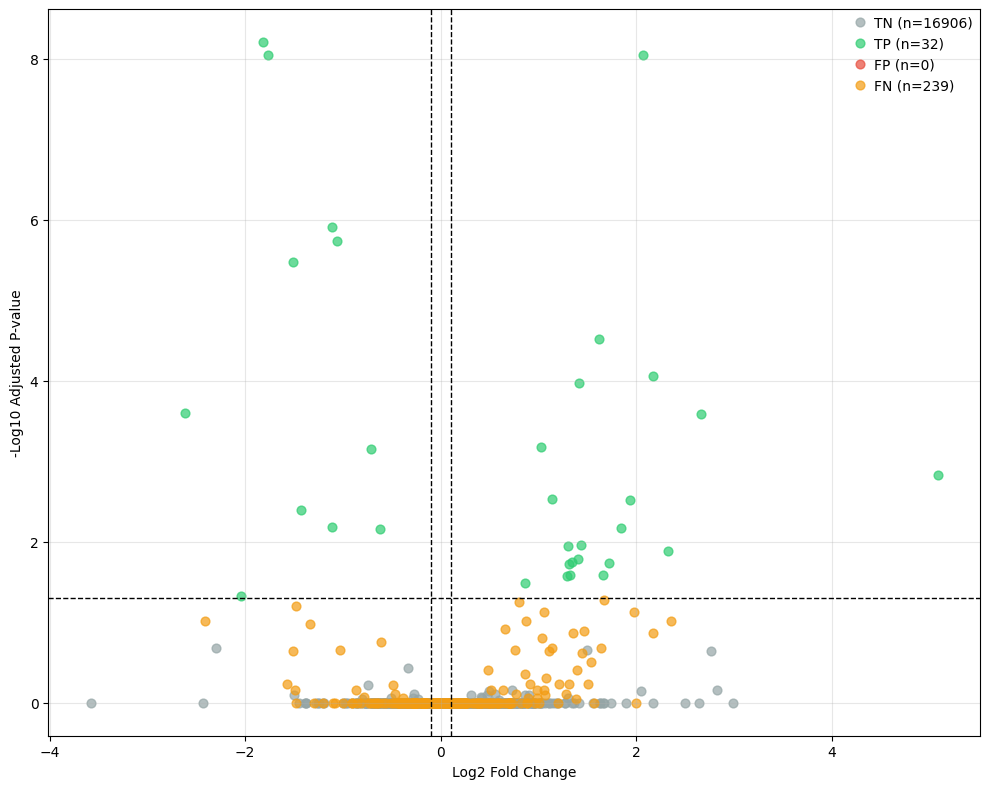

In [20]:
df["is_true_DEG"] = df[GENE_COL_NAME].isin(pert_df.gene_id.tolist())

df["TP"] = (df["is_true_DEG"] == True)  & (df["is_significant"] == True)
df["TN"] = (df["is_true_DEG"] == False) & (df["is_significant"] == False)
df["FP"] = (df["is_true_DEG"] == False) & (df["is_significant"] == True)
df["FN"] = (df["is_true_DEG"] == True)  & (df["is_significant"] == False)

colors = {
    'TP': '#2ecc71',  # Green - correctly identified DEGs
    'TN': '#95a5a6',  # Gray - correctly identified non-DEGs
    'FP': '#e74c3c',  # Red - incorrectly called significant
    'FN': '#f39c12'   # Orange - missed true DEGs
}

# One analysis for each method
for _, df_g in df.groupby("method"): 
    print(_)

    # Confussion matrix
    cm_df = pd.crosstab(df_g["is_true_DEG"], df_g["is_significant"], normalize="all")
    sns.heatmap(cm_df, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Calculate performance metrics
    tp = df_g['TP'].sum()
    tn = df_g['TN'].sum()
    fp = df_g['FP'].sum()
    fn = df_g['FN'].sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"\nPrecision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Accuracy:  {accuracy:.3f}")



    # Volcano plot
    df_g['-log10_pval'] = -np.log10(df_g[ADJ_P_VAL_COL_NAME].replace(0, 1e-300))

    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot each category
    for category in ['TN', 'TP', 'FP', 'FN']:
        data = df_g[df_g[category]]
        ax.scatter(data[LOGFC_COL_NAME], data['-log10_pval'],
                   c=colors[category], s=40, alpha=0.7, 
                   label=f'{category} (n={len(data)})')
    
    # Thresholds
    ax.axhline(-np.log10(PVAL_THR), color='black', linestyle='--', lw=1)
    ax.axvline(LOGFC_THR, color='black', linestyle='--', lw=1)
    ax.axvline(-LOGFC_THR, color='black', linestyle='--', lw=1)
    
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_yscale("linear")
    #ax.set_title(f'{method} - Volcano Plot')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [15]:
# Check if low cell counts causing high variance
print(adata_pb_all.obs[['psbulk_cells', 'psbulk_counts']].describe())

       psbulk_cells  psbulk_counts
count     76.000000   7.600000e+01
mean    2521.565789   1.904915e+08
std     1571.582662   1.554022e+08
min      500.000000   2.433884e+07
25%     1469.750000   8.985498e+07
50%     1946.000000   1.343093e+08
75%     2991.500000   2.309122e+08
max     8416.000000   7.705945e+08


AnnData object with n_obs × n_vars = 156660 × 38606 backed at '/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/Striatum/Striatum_Oligodendrocyte.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5'
    var: 'highly_variable'
    uns: 'cell_class_colors', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs'
    obsp: 'connect

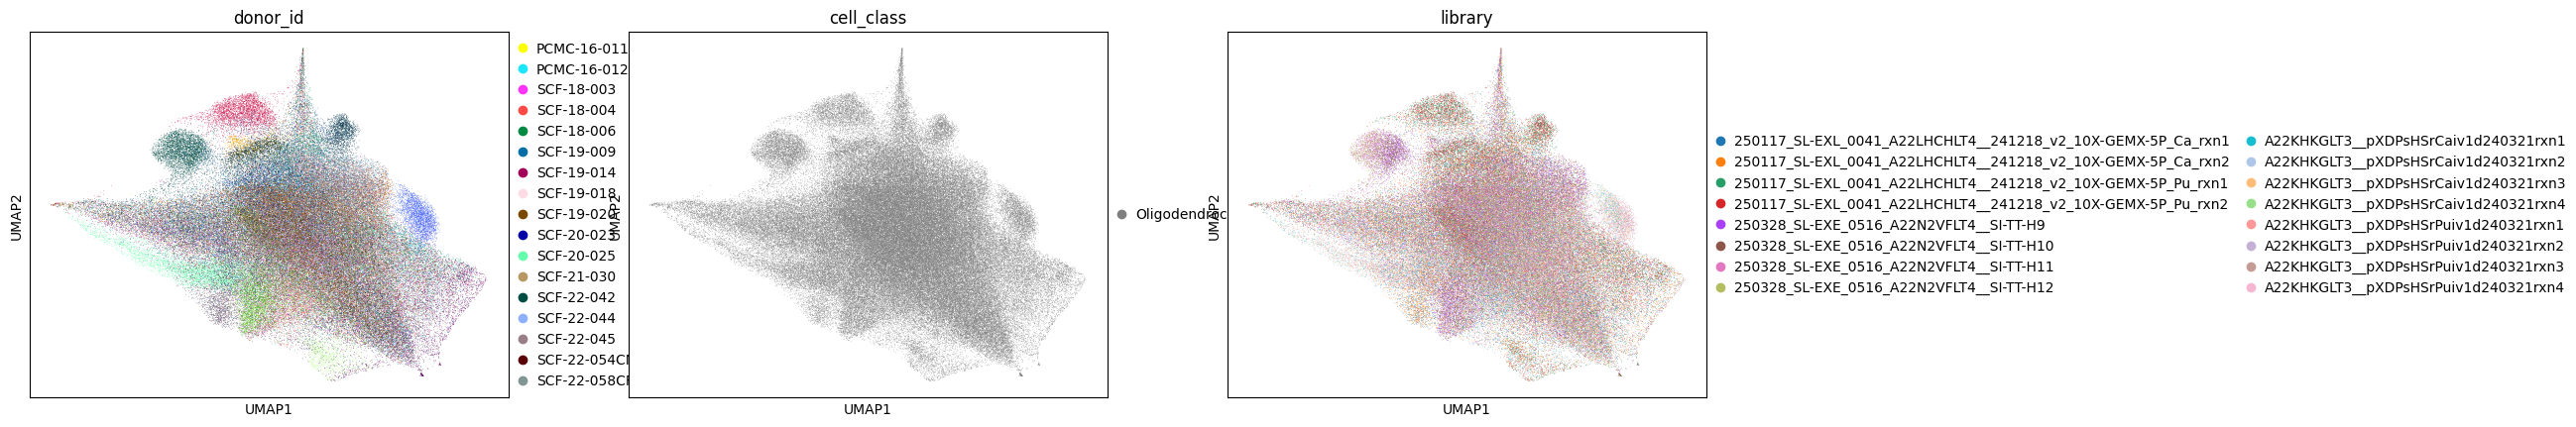

In [3]:
a = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/Striatum/Striatum_Oligodendrocyte.h5ad", backed="r")
print(a)
sc.pl.umap(a, color=["donor_id", "cell_class", "library"])